```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is used to create figures that illustrates how the 
optimal proposal pull acts on a particle.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Optimal proposal pull figures

Plan:
- Initiate an ensemble with 5 members with zeros + 100*q + 10*q, and make a keepInfoPlot-plot to see that this ensemble can be used. Use a fixed seed and numpy random numbers on the host to make it reproducible.
- Size should be small enough so that only one drifter is sufficient. Should use interpolation factor 5, and we get an influence radius of 45 grid cells. So we need grid that is of size 120x120.
- Drifter should be in position (x,y) = (40, 70).

Disclaimer:
- These figures are highly dependent on the random behavior of the model error, and are therefore not exactly reproducable.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from scipy.special import lambertw

import pycuda.driver as cuda

import os
import sys
import datetime
from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':16})
rc('text', usetex=True)
rc('xtick', labelsize=14)     
rc('ytick', labelsize=14)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic, config

from SWESimulators import BathymetryAndICs as BC
from SWESimulators import OceanStateNoise
from SWESimulators import OceanNoiseEnsemble
from SWESimulators import BaseOceanStateEnsemble
from SWESimulators import DataAssimilationUtils as dautils
from SWESimulators import IEWPFOcean
from SWESimulators import EnsemblePlot


In [2]:
%cuda_context_handler gpu_ctx
%setup_logging --out iewpf_2stage_gpu.log --file_level $config.GPUOceanLoggerLevels.IEWPF_DEBUG.value

Console logger using level INFO
File logger using level Level 15 to iewpf_2stage_gpu.log
Python version 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]


In [3]:
#Create output directory for images
imgdir='optimal_proposal_pull_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
imgdir = imgdir + "/"
print("Saving figures to " + imgdir)

Saving figures to optimal_proposal_pull_2020_11_20-14_39_11/


# Testing two-stage IEWPF

Here, we make a test of the entire two-stage IEWPF algorithm applied to a suitable test case.

In [4]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 120, "ny": 120,
    #"nx": 15, "ny": 15,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 5,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals(): 
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(PlotHelper)
reload(dautils)
reload(IEWPFOcean)

sim = CDKLM16.CDKLM16(**sim_args)

# Initial perturbation
rand_nx, rand_ny = sim.small_scale_model_error.rand_nx, sim.small_scale_model_error.rand_ny
init_rand = np.random.normal(size=(rand_ny, rand_nx))
sim.small_scale_model_error.random_numbers.upload(sim.gpu_stream, init_rand)
sim.small_scale_model_error.perturbSim(sim, q0_scale=100, update_random_field=False)
    
eta_init, hu_init, hv_init = sim.download(True)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 5,
    "num_drifters": 1,
    "sim": sim,
    "observation_type": dautils.ObservationType.DirectUnderlyingFlow,
    "observation_variance": 0.015**2 #0.02**2
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

iewpfOcean = IEWPFOcean.IEWPFOcean(ensemble, debug=False, show_errors=True)

print ("Ready!")
#ensemble.plotEnsemble()

q0:  0.00028492201548162456
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (120, 120)
max_dt:  0.09067530184984207
Ready!


In [5]:
# Set drifter position
ensemble.setTrueDrifterPositions([[75.5*ensemble.dx,40.5*ensemble.dy]])
#ensemble.setTrueDrifterPositions([[35.5*ensemble.dx,35.5*ensemble.dy]])

for particle in ensemble.particles:
    perturbation = np.random.normal(size=(rand_ny, rand_nx))
    particle.small_scale_model_error.random_numbers.upload(particle.gpu_stream, perturbation)
    particle.small_scale_model_error.perturbSim(particle, q0_scale=30, update_random_field=False)
    
ensemble.step(ensemble.dt)

0.05000000074505806

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
hei


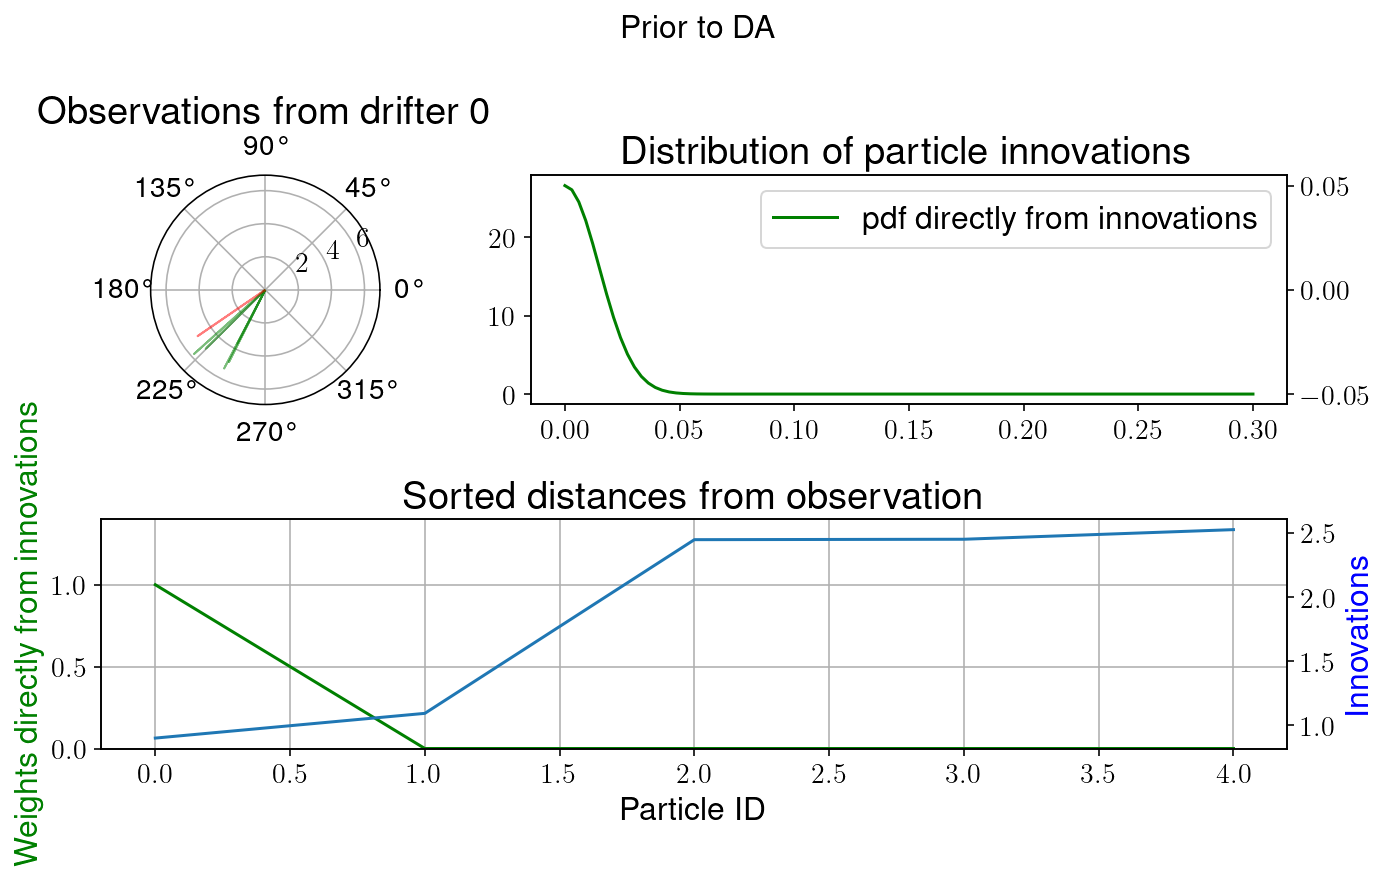

In [6]:
EnsemblePlot.plotVelocityInfo(ensemble, title="Prior to DA")

print("hei")

In [7]:
print(ensemble.getInnovations())

[[[-2.40653808  0.43942319]]

 [[-1.89099464  1.55710708]]

 [[-1.60607157  1.94767717]]

 [[-0.50313016  0.74797221]]

 [[ 0.21101944  1.07346437]]]


In [8]:
ideal_particle=2

In [9]:
eta_cmap = 'BrBG'
huv_cmap = 'RdBu'

def showMatrices3(eta, hu, hv, title, drifterPositions=None, ensemble=None):
    num_cols = 3
    min_velocity = min(np.min(hu), np.min(hv))
    max_velocity = max(np.max(hu), np.max(hv))
    
    fig = plt.figure(figsize=(12,4))
    ax = plt.subplot(1,num_cols,1)
    plt.imshow(eta, origin="lower", interpolation="None", cmap=eta_cmap)
    if drifterPositions is not None:
        _markDriftersInImshow(ax, drifterPositions, ensemble)
    
    ax = plt.subplot(1,num_cols,2)
    plt.imshow(hu, origin="lower", interpolation="None", 
               vmin=min_velocity, vmax=max_velocity, cmap=huv_cmap)
    if drifterPositions is not None:
        _markDriftersInImshow(ax, drifterPositions, ensemble)

    ax = plt.subplot(1, num_cols, 3)
    plt.imshow(hv, origin="lower", interpolation="None", 
           vmin=min_velocity, vmax=max_velocity, cmap=huv_cmap)
    if drifterPositions is not None:
        _markDriftersInImshow(ax, drifterPositions, ensemble)


def imshow(data, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(data[2:-2,2:-2], interpolation=interpolation, origin='lower', cmap=eta_cmap)
    else:
        im = plt.imshow(data, interpolation=interpolation, origin='lower', cmap=eta_cmap)
    
    plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=15)
    ny, nx = data.shape
    axis_label_text = r'$\Omega^R$'
    if ny == ensemble.ny:
        axis_label_text = r'$\Omega^M$'
    axis_label = plt.text(-nx/6, -ny/6, axis_label_text, fontsize=15)

        
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(13,4), interior=False, infotext=None):

    ny, nx = eta.shape
    axis_label_text = r'$\Omega^R$'
    if ny == ensemble.ny:
        axis_label_text = r'$\Omega^M$'
    
    fig = None
    axs = None
    if infotext is None:
        fig, axs = plt.subplots(1,3, figsize=figsize)
    else:
        fig, axs = plt.subplots(1,4, figsize=(figsize[0]*1.33, figsize[1]))
    
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    axs[0].set_title("$\eta$", fontsize=14)
    plt.colorbar(eta_im, ax=axs[0])
    axis_label = axs[0].text(-nx/6, -ny/6, axis_label_text, fontsize=15)
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[1].set_title("$hu$", fontsize=14)
    plt.colorbar(hu_im, ax=axs[1])
    axis_label = axs[1].text(-nx/6, -ny/6, axis_label_text, fontsize=15)
    
    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[2].set_title("$hv$", fontsize=14)
    plt.colorbar(hv_im, ax=axs[2])
    axis_label = axs[2].text(-nx/6, -ny/6, axis_label_text, fontsize=15)

    if infotext is not None:
        axs[3].text(0.5, 0.5, infotext, ha='center')

    plt.subplots_adjust(top=0.88)                        
    if title is not None:
        if infotext is None:
            plt.suptitle(title,  y=1.00, fontsize=16)
        else: 
            plt.suptitle(title, x=3.0/8.0,  y=1.00, fontsize=16)
            
    plt.tight_layout()
    return fig
        
def createInnovationPlot(ensemble, particle_id, S, innovation_pre=None, particle_velocity_pre=None):
    drifter_position = ensemble.observeTrueDrifters()[0,:]
    true_velocity = ensemble.observeTrueState()[0, 2:]
    all_particle_velocities = ensemble.observeParticles()
    particle_velocity = ensemble.observeParticles()[particle_id,0,:]
    innovation = ensemble.getInnovations()[particle_id,0,:]
    
    print("drifter_position", drifter_position)
    print("true_velocity", true_velocity)
    #print("all_particle_velocities", all_particle_velocities)    
    print("particle_velocity", particle_velocity)
    print("innovation: ", innovation)
    
    cell_id_x = int(np.floor(drifter_position[0]/ensemble.dx))
    cell_id_y = int(np.floor(drifter_position[1]/ensemble.dy))
    print("cell_id: ", (cell_id_x, cell_id_y))
    
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)
    ax.imshow(np.zeros((ensemble.ny, ensemble.nx))*np.nan, origin="lower")

    print("S: ", S)
    print("S*d: ", np.dot(S, innovation))#S*ensemble.getInnovations()[particle_id,:,:].transpose)

    circ = matplotlib.patches.Circle((cell_id_x, cell_id_y), 2, fill=False)
    ax.add_patch(circ)
    
    # Add observed particle and truth
    arrow_scale = 10
    
    if particle_velocity_pre is None:
        particle_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                 particle_velocity[0]*arrow_scale, 
                                                 particle_velocity[1]*arrow_scale, \
                                                 color='xkcd:electric pink', width=0.7)
    else:
        particle_arrow_pre = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                 particle_velocity_pre[0]*arrow_scale, 
                                                 particle_velocity_pre[1]*arrow_scale, \
                                                 color='xkcd:electric pink', width=0.7, alpha=0.2)
        particle_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                                 particle_velocity[0]*arrow_scale, 
                                                 particle_velocity[1]*arrow_scale, \
                                                 color='xkcd:electric pink', width=0.7)
        
    ax.add_patch(particle_arrow)
    
    truth_arrow = matplotlib.pyplot.arrow(cell_id_x, cell_id_y, 
                                          true_velocity[0]*arrow_scale, 
                                          true_velocity[1]*arrow_scale, \
                                          color='xkcd:azure', width=0.7)
    ax.add_patch(truth_arrow)
    
    if innovation_pre is None:
        innovation_arrow = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                   cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                   innovation[0]*arrow_scale, 
                                                   innovation[1]*arrow_scale, 
                                                   #linestyle=':',
                                                   color='xkcd:dark slate blue', width=0.7)
    else:
        innovation_arrow_pew = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                   cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                   innovation_pre[0]*arrow_scale, 
                                                   innovation_pre[1]*arrow_scale, 
                                                   #linestyle=':', 
                                                   alpha=0.2,
                                                   color='xkcd:dark slate blue', width=0.7)

        innovation_arrow = matplotlib.pyplot.arrow(cell_id_x, #+particle_velocity[0]*arrow_scale, 
                                                   cell_id_y, #+particle_velocity[1]*arrow_scale, 
                                                   innovation[0]*arrow_scale, 
                                                   innovation[1]*arrow_scale, 
                                                   #linestyle=':',
                                                   color='xkcd:dark slate blue', width=0.7)

        
    ax.add_patch(innovation_arrow)
    
    text_observation = plt.text(cell_id_x+true_velocity[0]*arrow_scale-10, 
                                cell_id_y+true_velocity[1]*arrow_scale+5, 
                                r'$y^n$', fontsize=15)
    
    if particle_velocity_pre is None:
        text_particle = plt.text(cell_id_x+particle_velocity[0]*arrow_scale-15, 
                                 cell_id_y+particle_velocity[1]*arrow_scale-10, 
                                 r'$H(\psi^{n,f})$', fontsize=15)
    else:
        # Same position as in if
        text_particle = plt.text(cell_id_x+particle_velocity_pre[0]*arrow_scale-15, 
                                 cell_id_y+particle_velocity_pre[1]*arrow_scale-10, 
                                 r'$H(\psi^{n,f})$', fontsize=15, alpha=0.4)
        text_particle = plt.text(cell_id_x+particle_velocity[0]*arrow_scale-32, 
                                 cell_id_y+particle_velocity[1]*arrow_scale-2, 
                                 r'$H(\psi^{n,a})$', fontsize=15)
        
    if innovation_pre is None:
        text_innovation = plt.text(cell_id_x+innovation[0]*arrow_scale-40, 
                                   cell_id_y+innovation[1]*arrow_scale+5, 
                                   r'$d^n = y^n - H(\psi^{n,f})$', fontsize=15)
    else:
        # Same position as in if
        text_innovation = plt.text(cell_id_x+innovation_pre[0]*arrow_scale-40, 
                                   cell_id_y+innovation_pre[1]*arrow_scale+5, 
                                   r'$d^n = y^n - H(\psi^{n,f})$', fontsize=15, alpha=0.4)
        text_innovation = plt.text(cell_id_x+innovation[0]*arrow_scale-25, 
                                   cell_id_y+innovation[1]*arrow_scale-15, 
                                   r'$d^n = y^n - H(\psi^{n,a})$', fontsize=15)
        
    
    #ax.annotate('', xy=(1.2, 0.3), xycoords='axes fraction', xytext=(1.1, 0.4), 
    #        arrowprops=dict(arrowstyle="->", color='green'))
    #fig.canvas.draw()

    axis_label = plt.text(-ensemble.nx/7, -ensemble.ny/7, r'$\Omega^M$', fontsize=15)

    plt.title('Observation, particle state and innovation', fontsize=15)
    
    return ax
            


drifter_position [301.97772 161.9875 ]
true_velocity [-4.08133793 -2.79239511]
particle_velocity [-2.48191094 -4.74461842]
innovation:  [-1.60607157  1.94767717]
cell_id:  (75, 40)
S:  [[ 9.6971326e+02 -5.1008725e-13]
 [-4.0958369e-13  9.6971326e+02]]
S*d:  [[-1557.42889418  1888.68836835]]


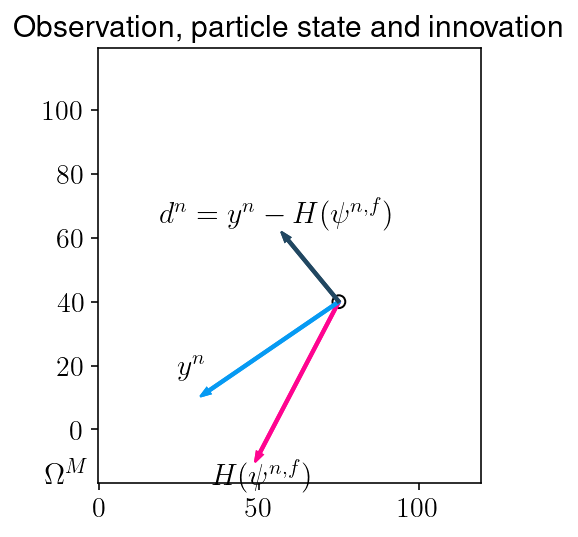

In [10]:
drifter_position_pre = ensemble.observeTrueDrifters()[0,:]
true_velocity_pre = ensemble.observeTrueState()[0, 2:]
all_particle_velocities_pre = ensemble.observeParticles()
particle_velocity_pre = ensemble.observeParticles()[ideal_particle,0,:]
innovation_pre = ensemble.getInnovations()[ideal_particle,0,:]

ax = createInnovationPlot(ensemble, ideal_particle, iewpfOcean.S_host)
plt.savefig(imgdir + "1_vectors.pdf", bbox_inches="tight", format='pdf')

S*d:  [[-1557.42889418  1888.68836835]]
cell_id:  (15, 8)
yeah...


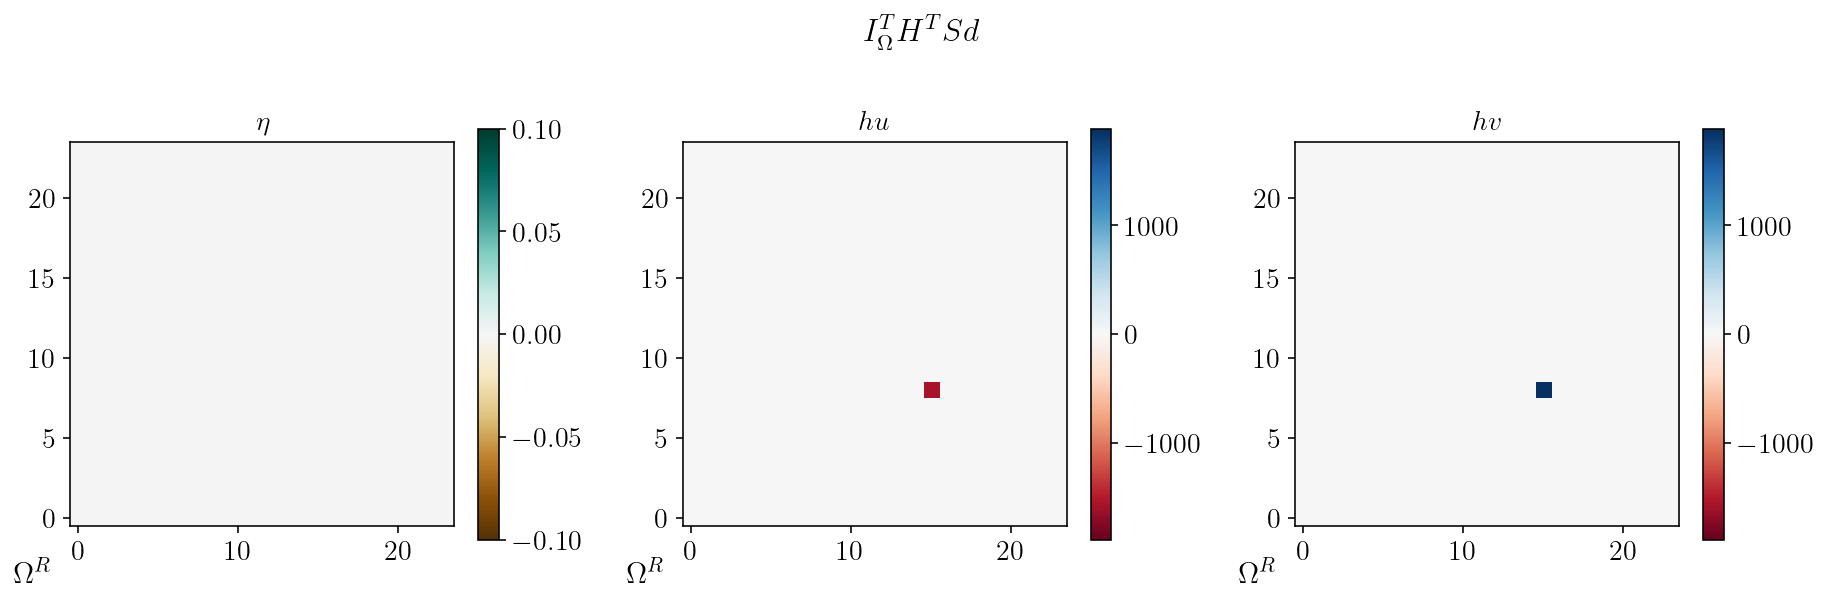

In [11]:
# Innovation times S
S = iewpfOcean.S_host
innovation = ensemble.getInnovations()[ideal_particle,0,:]

Sd = np.dot(S, innovation)
print("S*d: ", Sd)#S*ensemble.getInnovations()[particle_id,:,:].transpose)

drifter_position = ensemble.observeTrueDrifters()[0,:]
coarse_dx = ensemble.particles[ideal_particle].small_scale_model_error.coarse_dx
coarse_dy = ensemble.particles[ideal_particle].small_scale_model_error.coarse_dy
coarse_cell_id_x = int(np.floor(drifter_position[0]/coarse_dx))
coarse_cell_id_y = int(np.floor(drifter_position[1]/coarse_dy))
print("cell_id: ", (coarse_cell_id_x, coarse_cell_id_y))

rand_nx, rand_ny = sim.small_scale_model_error.rand_nx, sim.small_scale_model_error.rand_ny
zero_buffer = np.zeros((rand_ny, rand_nx), dtype=np.float32)

IHSd_eta = zero_buffer.copy()
IHSd_hu  = zero_buffer.copy()
IHSd_hv  = zero_buffer.copy()

IHSd_hu[coarse_cell_id_y, coarse_cell_id_x] = Sd[0,0]
IHSd_hv[coarse_cell_id_y, coarse_cell_id_x] = Sd[0,1]

imshow3(IHSd_eta, IHSd_hu, IHSd_hv,
        title=r'$I^T_{\Omega}  H^T S d$')

plt.savefig(imgdir + "2_innovation_in_statespace.pdf", bbox_inches="tight", format='pdf')

print("yeah...")

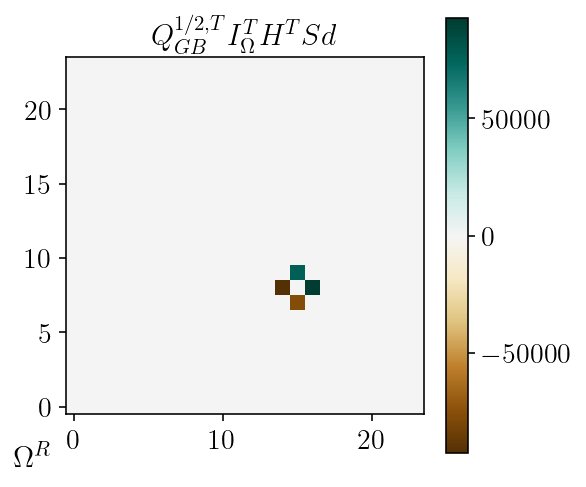

In [12]:
QgbTIHSd  = zero_buffer.copy()

geoBalanceConst = iewpfOcean.geoBalanceConst

j = coarse_cell_id_y
i = coarse_cell_id_x

QgbTIHSd[j+1, i  ] = -Sd[0,0]*geoBalanceConst/coarse_dy
QgbTIHSd[j-1, i  ] =  Sd[0,0]*geoBalanceConst/coarse_dy
QgbTIHSd[j  , i+1] =  Sd[0,1]*geoBalanceConst/coarse_dx
QgbTIHSd[j  , i-1] = -Sd[0,1]*geoBalanceConst/coarse_dx

#// the x-component of the innovation spreads to north and south
#shared_huhv[0] = -e_x_*geoBalanceConst_/dy_; // north 
#shared_huhv[2] =  e_x_*geoBalanceConst_/dy_; // south
#// the y-component of the innovation spreads to east and west
#shared_huhv[1] =  e_y_*geoBalanceConst_/dx_; // east
#shared_huhv[3] = -e_y_*geoBalanceConst_/dx_; // west


imshow(QgbTIHSd, title=r'$Q^{1/2, T}_{GB} I^T_{\Omega}  H^T S d$')

plt.savefig(imgdir + "3_innovation_five_point.pdf", bbox_inches="tight", format='pdf')

In [13]:

iewpfOcean.setNoiseBufferToZero(ensemble.particles[ideal_particle])
        
local_innovation = innovation
observed_drifter_position = drifter_position

cell_id_x = np.int32(int(np.floor(observed_drifter_position[0]/iewpfOcean.dx)))
cell_id_y = np.int32(int(np.floor(observed_drifter_position[1]/iewpfOcean.dy)))
coarse_cell_id_x = np.int32(int(np.floor(observed_drifter_position[0]/iewpfOcean.coarse_dx)))
coarse_cell_id_y = np.int32(int(np.floor(observed_drifter_position[1]/iewpfOcean.coarse_dy)))

# 1) Solve linear problem
e = np.dot(iewpfOcean.S_host, local_innovation)

iewpfOcean.halfTheKalmanGainKernel.prepared_async_call(iewpfOcean.global_size_Kalman,
                                                 iewpfOcean.local_size_Kalman,
                                                 ensemble.particles[ideal_particle].gpu_stream,
                                                 iewpfOcean.coarse_nx, iewpfOcean.coarse_ny, 
                                                 iewpfOcean.coarse_dx, iewpfOcean.coarse_dy,
                                                 iewpfOcean.soar_q0, iewpfOcean.soar_L,
                                                 coarse_cell_id_x, coarse_cell_id_y,
                                                 iewpfOcean.geoBalanceConst,
                                                 np.float32(e[0,0]), np.float32(e[0,1]),
                                                 ensemble.particles[ideal_particle].small_scale_model_error.random_numbers.data.gpudata,
                                                 ensemble.particles[ideal_particle].small_scale_model_error.random_numbers.pitch)

half_kalman_gain = ensemble.particles[ideal_particle].small_scale_model_error.getRandomNumbers()


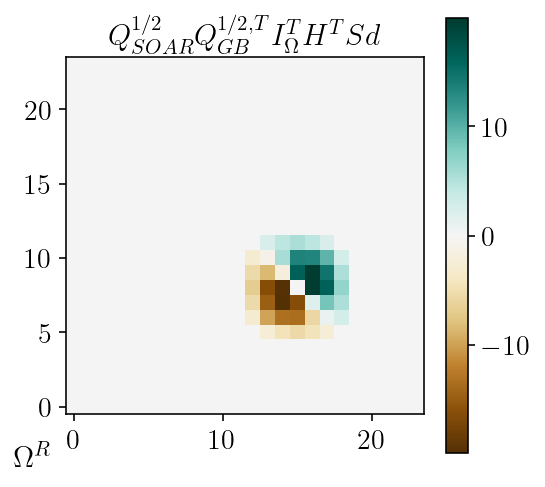

In [14]:
imshow(half_kalman_gain, title=r'$Q^{1/2}_{SOAR}Q^{1/2, T}_{GB} I^T_{\Omega}  H^T S d$')

plt.savefig(imgdir + "4_soar1.pdf", bbox_inches="tight", format='pdf')

In [15]:
## Store the state prior to adding 
## the Kalman gain, so that we 
## can subtract it for plotting the
## contribution.

pre_eta, pre_hu, pre_hv = ensemble.particles[ideal_particle].download(interior_domain_only=True)

In [16]:
iewpfOcean.addKalmanGain(ensemble.particles[ideal_particle], 
                         ensemble.observeTrueDrifters(), 
                         ensemble.getInnovations()[ideal_particle])

6179.897480922091

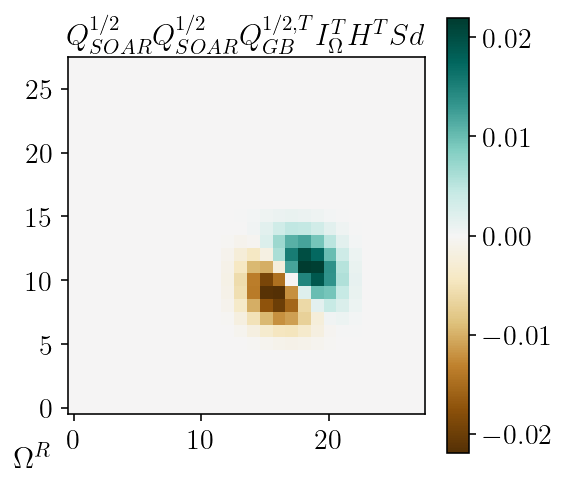

In [17]:
half_kalman_gain_soar = ensemble.particles[ideal_particle].small_scale_model_error.getCoarseBuffer()
imshow(half_kalman_gain_soar, 
       title=r'$Q^{1/2}_{SOAR}Q^{1/2}_{SOAR}Q^{1/2, T}_{GB} I^T_{\Omega}  H^T S d$')
plt.savefig(imgdir + "5_soar2.pdf", bbox_inches="tight", format='pdf')

In [18]:
post_eta, post_hu, post_hv = ensemble.particles[ideal_particle].download(interior_domain_only=True)
kalman_eta = post_eta - pre_eta
kalman_hu  = post_hu  - pre_hu
kalman_hv  = post_hv  - pre_hv

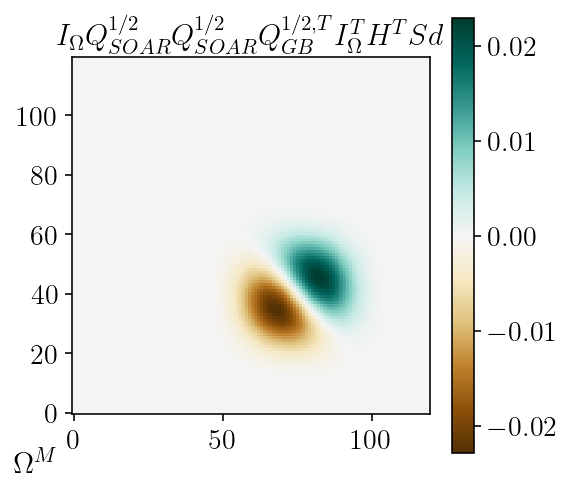

In [19]:


imshow(kalman_eta,
       title=r'$I_{\Omega}Q^{1/2}_{SOAR}Q^{1/2}_{SOAR}Q^{1/2, T}_{GB} I^T_{\Omega}  H^T S d$')
plt.savefig(imgdir + "6_interpolation.pdf", bbox_inches="tight", format='pdf')

hei


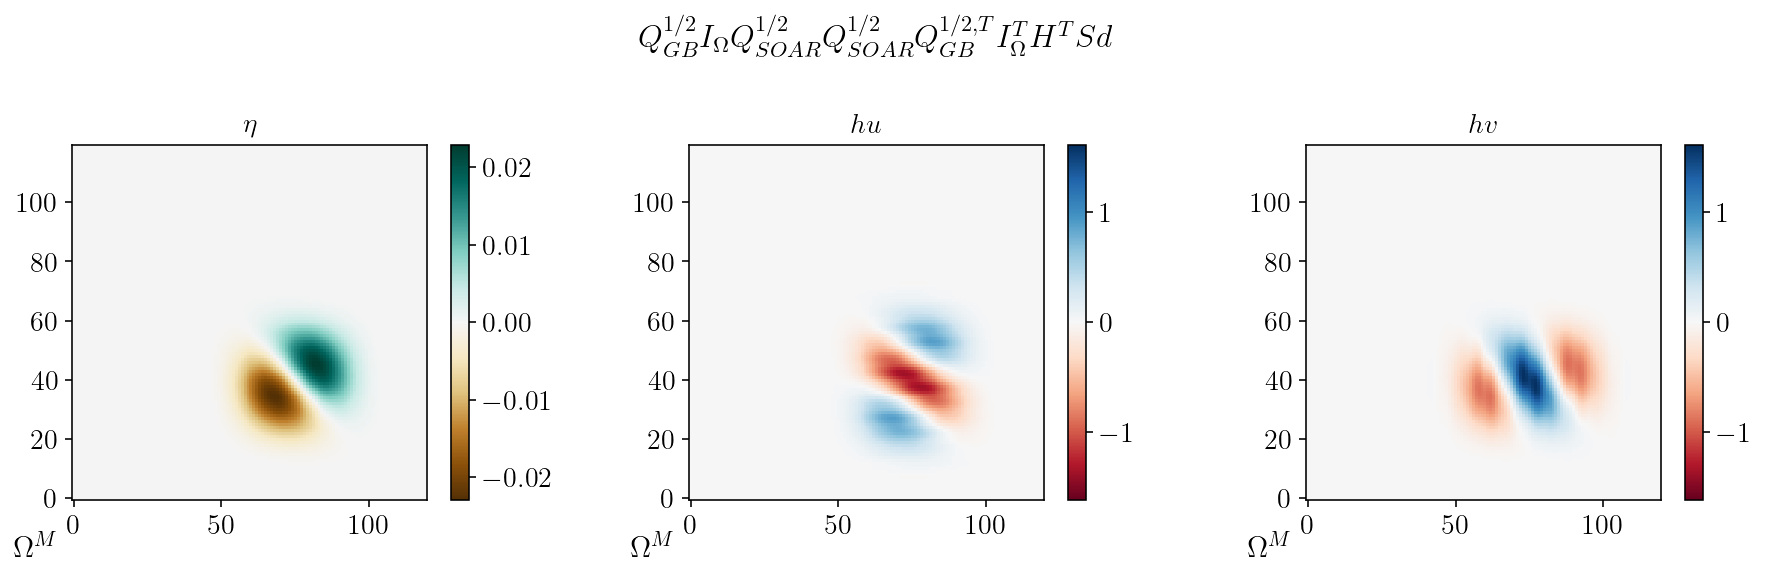

In [20]:
imshow3(kalman_eta, kalman_hu, kalman_hv,
        title=r'$Q^{1/2}_{GB}I_{\Omega}Q^{1/2}_{SOAR}Q^{1/2}_{SOAR}Q^{1/2, T}_{GB} I^T_{\Omega}  H^T S d$')
print("hei")
#plt.suptitle(r'$Q^{1/2}_{GB}I_{\Omega}Q^{1/2}_{SOAR}Q^{1/2}_{SOAR}Q^{1/2, T}_{GB} I^T_{\Omega}  H^T S d$', 
#             y=1.0, fontsize=14)
plt.tight_layout()
plt.savefig(imgdir + "7_thepull.pdf", bbox_inches="tight", format='pdf')

drifter_position [301.97772 161.9875 ]
true_velocity [-4.08133793 -2.79239511]
particle_velocity [-3.73756075 -3.22189617]
innovation:  [-0.35042177  0.42495492]
cell_id:  (75, 40)
S:  [[ 9.6971326e+02 -5.1008725e-13]
 [-4.0958369e-13  9.6971326e+02]]
S*d:  [[-339.80863226  412.0844216 ]]


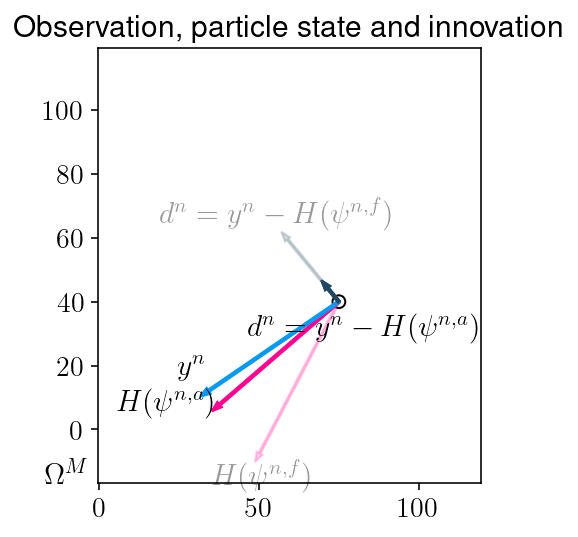

In [21]:
ax = createInnovationPlot(ensemble, ideal_particle, iewpfOcean.S_host, innovation_pre, particle_velocity_pre)
plt.savefig(imgdir + "8_post_kalman_state.pdf", format='pdf')

In [22]:
print(imgdir)

optimal_proposal_pull_2020_11_20-14_39_11/
